# Auditory oddball ERP experiment with pre-defined trial structure

In [1]:
# go up one folder to main notebooks folder

In [2]:
cd ..

C:\Users\john_griffiths\Code\libraries_of_mine\github\eeg-notebooks\notebooks


## Setup

In [3]:
from muselsl import stream, list_muses, view, record
from multiprocessing import Process
from mne import Epochs, find_events
from time import time, strftime, gmtime
import os
from stimulus_presentation import n170
from utils import utils
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

from scipy.io import loadmat

from sandbox import auditory_erp_arrayin

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


Load in trial structure

In [4]:
dm_file = 'sandbox/designMatrix.mat'
dm = loadmat(dm_file)['designMatrix'].T

In [5]:
stim_types = dm[:,0].astype(int)-1
stim_types

array([1, 1, 0, ..., 0, 0, 0])

In [6]:
itis = dm[:,2] * 0.001
itis

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

Test run of stimulus delivery

In [7]:
trialses = auditory_erp_arrayin.present(duration=10,stim_types=stim_types,itis=itis)

1.3287 	WARNING 	We strongly recommend you activate the PTB sound engine in PsychoPy prefs as the preferred audio engine. Its timing is vastly superior. Your prefs are currently set to use ['sounddevice', 'PTB', 'pyo', 'pygame'] (in that order).
5.5067 	WARNING 	User requested fullscreen with size [1920 1080], but screen is actually [1366, 768]. Using actual size
6.9634 	WARNING 	Use of rgb arguments to stimuli are deprecated. Please use color and colorSpace args instead


In [8]:
trialses

,sound_ind,iti
0,1,0.5
1,1,0.5
2,0,0.5
3,1,0.5
4,1,0.5
...,...,...
1795,0,0.5
1796,0,0.5
1797,0,0.5
1798,0,0.5


## Collect EEG data

In [9]:
# Define these parameters 
duration = 20 # 120 # in seconds. 120 is recommended
subject = 1 # unique id for each participant
session = 1 # represents a data collection session. Multiple trials can be performed for each session

Seat the subject in front of the computer and run the following cell to run a single trial of the experiment.

In order to maximise the possibility of success, participants should take the experiment in a quiet environment and do their best to minimize movement that might contaminate the signal. With their jaw and face relaxed, subjects should focus on the stimuli, mentally noting whether they see a "face" or a "house".

Data will be recorded into CSV files in the `eeg-notebooks/data` directory

In [27]:
recording_path = os.path.join(os.path.split(os.getcwd())[0],'data', 'auditory', 'oddball_erp_arrayin', 
                              "subject" + str(subject), "session" + str(session), ("recording_%s.csv" %
                                              strftime("%Y-%m-%d-%H.%M.%S", gmtime())))
print('Recording data to: ', recording_path)
                                                                                   

Recording data to:  C:\Users\john_griffiths\Code\libraries_of_mine\github\eeg-notebooks\data\auditory\oddball_erp_arrayin\subject1\session1\recording_2020-03-13-19.27.53.csv


In [13]:
present_kwargs = {'duration': duration, 'stim_types': stim_types, 'itis': itis}

In [16]:
#stimulus = Process(target=n170.present, args=(duration,))
stimulus = Process(target=auditory_erp_arrayin.present, kwargs=present_kwargs)#(duration,stim_types,itis))

recording = Process(target=record, args=(duration, recording_path))

stimulus.start()
recording.start()

(Wait before running the next cell! )

In [29]:
assert os.path.isfile(recording_path)

AssertionError: 

## UP TO HERE

## Step 4: Prepare the Data for Analysis

Once a suitable data set has been collected, it is now time to analyze the data and see if we can identify the N170


### Load data into MNE objects

[MNE](https://martinos.org/mne/stable/index.html) is a very powerful Python library for analyzing EEG data. It provides helpful functions for performing key tasks such as filtering EEG data, rejecting artifacts, and grouping EEG data into chunks (epochs).

The first step to using MNE is to read the data we've collected into an MNE `Raw` object

In [22]:
#raw = utils.load_data('visual/N170', sfreq=256., 
#                      subject_nb=subject, session_nb=session)

In [23]:
raw = utils.load_muse_csv_as_raw([recording_path])

Creating RawArray with float64 data, n_channels=5, n_times=4968
    Range : 0 ... 4967 =      0.000 ...    19.402 secs
Ready.


### Visualizing the Power Spectrum

Plotting the power spectral density (PSD) of our dataset will give us a glimpse at the different frequencies that are present. We won't be able to see the N170 in the PSD, but it will give us an impression of how noisy our data was. A very noisy or flat PSD may represent poor signal quality at certain electrodes



Effective window size : 8.000 (s)


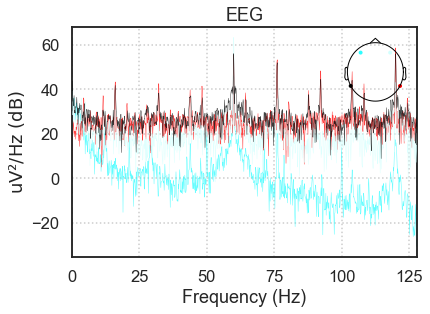

In [11]:
%matplotlib inline
raw.plot_psd();

This PSD looks good. There is a large peak at 60hz, representing background electrical activity.

### Filtering

Most ERP components are composed of lower frequency fluctuations in the EEG signal. Thus, we can filter out all frequencies between 1 and 30 hz in order to increase our ability to detect them.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

Effective window size : 8.000 (s)


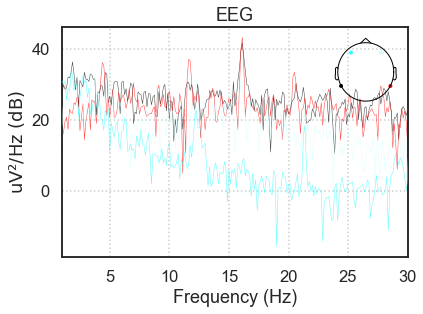

In [12]:
raw.filter(1,30, method='iir')
raw.plot_psd(fmin=1, fmax=30);

This PSD of frequencies between 1 and 30 hz looks good. The difference between the temporal channels (red and black) and the frontal channels (blue and green) is clearly evident. The huge peak from 1 to 3hz is largely due to the presence of eye blinks, which produce large amplitude, low-frequency events in the EEG.

### Epoching

Next, we will chunk (epoch) the data into segments representing the data 100ms before to 800ms after each stimulus. No baseline correction is needed (signal is bandpass filtered) and we will reject every epoch where the amplitude of the signal exceeded 75 uV, which should most eye blinks.

In [13]:
# Create an array containing the timestamps and type of each stimulus (i.e. face or house)
events = find_events(raw)
event_id = {'House': 1, 'Face': 2}

# Create an MNE Epochs object representing all the epochs around stimulus presentation
epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.1, tmax=0.8, baseline=None,
                reject={'eeg': 75e-6}, preload=True, 
                verbose=False, picks=[0,1,2,3])
print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
epochs

8 events found
Event IDs: [1 2]
sample drop %:  100.0


<Epochs  |   0 events (all good), -0.101562 - 0.800781 sec, baseline off, ~17 kB, data loaded,
 'Face': 0
 'House': 0>

Sample drop % is an important metric representing how noisy our data set was. If this is greater than 20%, consider ensuring that signal variances is very low in the raw EEG viewer and collecting more data

## Step 5: Analyze the Data

Finally, we can now analyze our results by averaging the epochs that occured during the different stimuli and looking for differences in the waveform


### Epoch average

With our `plot_conditions` utility function, we can plot the average ERP for all electrodes for both conditions:

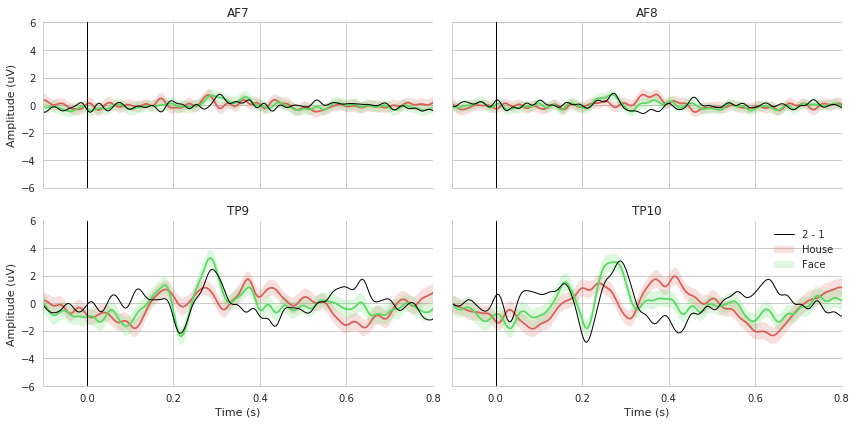

In [25]:
%matplotlib inline
conditions = OrderedDict()
conditions['House'] = [1]
conditions['Face'] = [2]

fig, ax = utils.plot_conditions(epochs, conditions=conditions, 
                                ci=97.5, n_boot=1000, title='',
                                diff_waveform=(1, 2))

Here we have a very nice deflection in the temporal channels around 200ms for face stimuli. This is likely the N170, although appearing slightly later due to delay in receiving the data over bluetooth. 

There's not much to see in the frontal channels (AF7 and AF8), but that's to be expected based on the fact that the N170 is mostly a lateral posterior brain phenomenon

### Decoding the N170

Next, we will use 4 different machine learning pipelines to classify the N170 based on the data we collected. The 

- **Vect + LR** :  Vectorization of the trial + Logistic Regression. This can be considered the standard decoding pipeline for MEG / EEG.
- **Vect + RegLDA** :  Vectorization of the trial + Regularized LDA. This one is very commonly used in P300 BCIs. It can outperform the previous one but become unusable if the number of dimension is too high.
- **ERPCov + TS**: ErpCovariance + Tangent space mapping. One of the most reliable Riemannian geometry-based pipeline.
- **ERPCov + MDM**: ErpCovariance + MDM. A very simple, yet effective (for low channel count), Riemannian geometry classifier.

Evaluation is done through cross-validation, with area-under-the-curve (AUC) as metric (AUC is probably the best metric for binary and unbalanced classification problem)

*Note: because we're doing machine learning here, the following cell may take a while to complete*

In [26]:
import pandas as pd
from sklearn.pipeline import make_pipeline

from mne.decoding import Vectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

from pyriemann.estimation import ERPCovariances, XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

from collections import OrderedDict

clfs = OrderedDict()

clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(estimator='oas'), MDM())
clfs['XdawnCov + TS'] = make_pipeline(XdawnCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['XdawnCov + MDM'] = make_pipeline(XdawnCovariances(estimator='oas'), MDM())

# format data
epochs.pick_types(eeg=True)
X = epochs.get_data() * 1e6
times = epochs.times
y = epochs.events[:, -1]

# define cross validation 
cv = StratifiedShuffleSplit(n_splits=20, test_size=0.25, 
                            random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    print(m)
    try:
        
        res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc', 
                              cv=cv, n_jobs=-1)
        auc.extend(res)
        methods.extend([m]*len(res))
    except:
        pass

Vect + LR
Vect + RegLDA
ERPCov + TS
ERPCov + MDM
XdawnCov + TS
XdawnCov + MDM


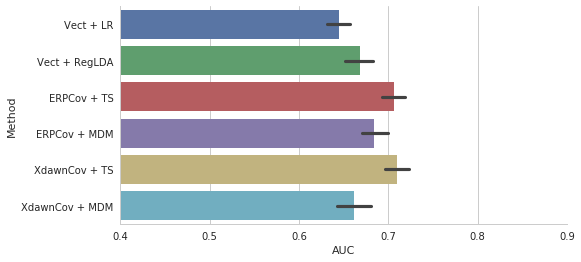

In [27]:
## Plot Decoding Results

import seaborn as sns
from matplotlib import pyplot as plt

    
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

fig = plt.figure(figsize=[8,4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.4, 0.9)
sns.despine()

The best classifiers for this data set appear to be the ERPCov and XdawnCov with tangent space projection pipelines. AUC is around .7, which is good, but on the low end for being able to run a brain-computer interface.

## Step 6: Share your Data!

How did your experiment go? If you're excited by your results we'd love to see your data!

Follow the instructions on our [Contributions](https://github.com/NeuroTechX/eeg-notebooks/blob/master/CONTRIBUTING.md) page to make a pull request with your data and we'll review it to be added to the EEG notebooks project.